In [1]:
#### Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import env
import wrangle_zillow
from os.path import exists
import scipy.stats as stats

from itertools import product
from scipy.stats import levene , pearsonr, spearmanr, mannwhitneyu, f_oneway, ttest_ind
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression, SelectKBest

from sklearn.cluster import KMeans
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

In [2]:
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.wrangle_zillow()

(28971, 23) (12417, 23) (10348, 23)
-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51736 entries, 1727539 to 1187175
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   basementsqft                51736 non-null  float64 
 1   bathrooms                   51736 non-null  float64 
 2   bedrooms                    51736 non-null  float64 
 3   area                        51736 non-null  float64 
 4   county                      51736 non-null  object  
 5   garagecarcnt                51736 non-null  float64 
 6   garagetotalsqft             51736 non-null  float64 
 7   latitude                    51736 non-null  float64 
 8   longitude                   51736 non-null  float64 
 9   lotsizesquarefeet           51736 non-null  float64 
 10  poolcnt                     51736 non-null  float64 
 11  structuretaxvaluedollarcnt  51736 non-null  float64 
 12  home_va

In [3]:
#
#train["aircon_encoded"] =  np.where(train.aircon == "None", 0,
#                                np.where(train.aircon == "Central", 1, 2))
#
#train["heating_encoded"] =  np.where(train.heating == "Central", 0,
#                                np.where(train.heating == "None", 1,
#                                np.where(train.heating == "Floor/Wall", 2, 3)))
#
#train["county_encoded"] =  np.where(train.county == "LA County", 0,
#                                np.where(train.county == "Orange County", 1, 2))

In [4]:
target = "logerror"

continous_list = [  'basementsqft',
                    'area',
                    'garagetotalsqft',
                    'latitude',
                    'longitude',
                    'lotsizesquarefeet',
                    'structuretaxvaluedollarcnt',
                    'home_value',
                    'landtaxvaluedollarcnt',
                    "tax_per_sqft",
                    'logerror',
                    'age',
                    "openness",
                    'est_tax_rate']

discrete_list = [   'aircon',
                    'bathrooms',
                    'bedrooms',
                    'home_size',
                    'logerror_bin',
                    'heating']

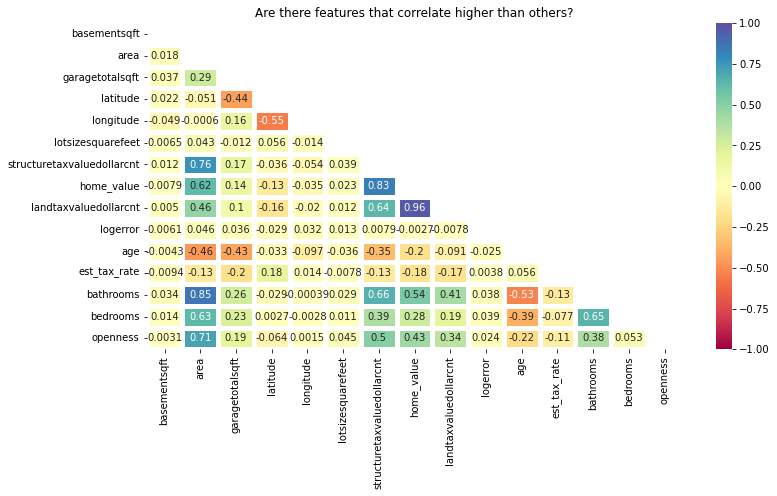

In [5]:
heatmap_list = ['basementsqft','area','garagetotalsqft','latitude','longitude',
                  'lotsizesquarefeet','structuretaxvaluedollarcnt','home_value',
                  'landtaxvaluedollarcnt','logerror','age','home_size','est_tax_rate',
                  "bathrooms","bedrooms","openness"]

plt.figure(figsize=(12, 6))

kwargs = {'alpha':1,
            'linewidth':5, 
            'linestyle':'--',
            'linecolor':'white'}

sns.heatmap(train[heatmap_list].corr(),
            #map="YlGnBu", 
            cmap="Spectral",
            mask=(np.triu(np.ones_like(train[heatmap_list].corr(),dtype=bool))),
            annot=True,
            vmin=-1, 
            vmax=1, 
            #annot=True,
            **kwargs
            )
plt.title("Are there features that correlate higher than others?")
plt.show()

observations: area, garagesqft,latt,long are best for correlation value with logerror
openness does not help that much

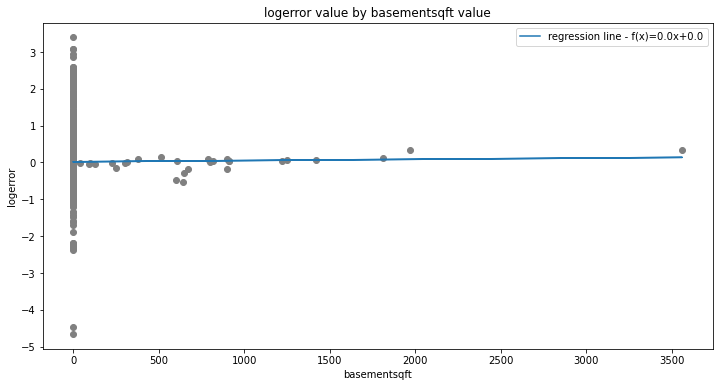

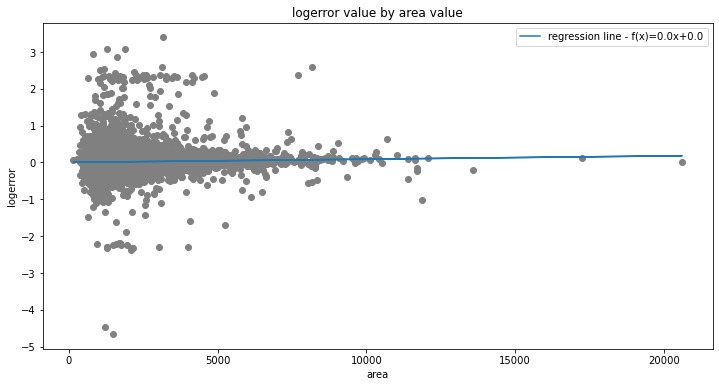

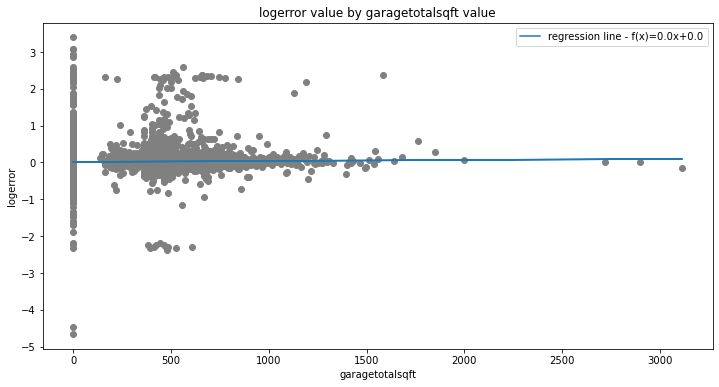

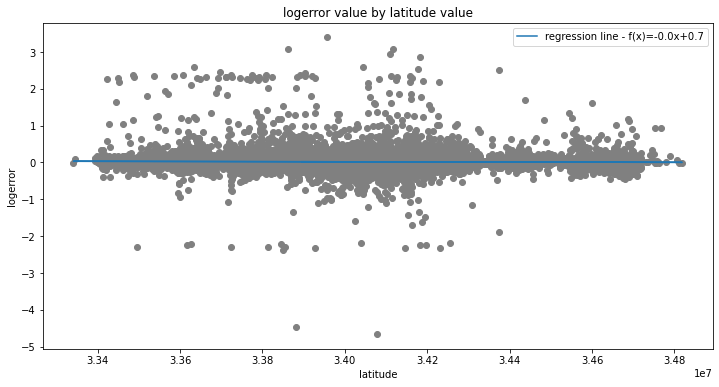

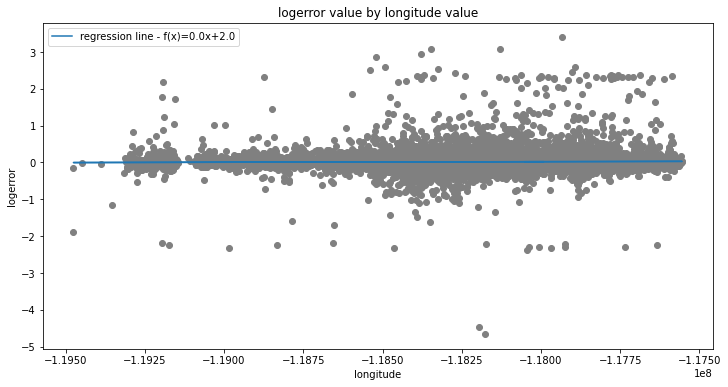

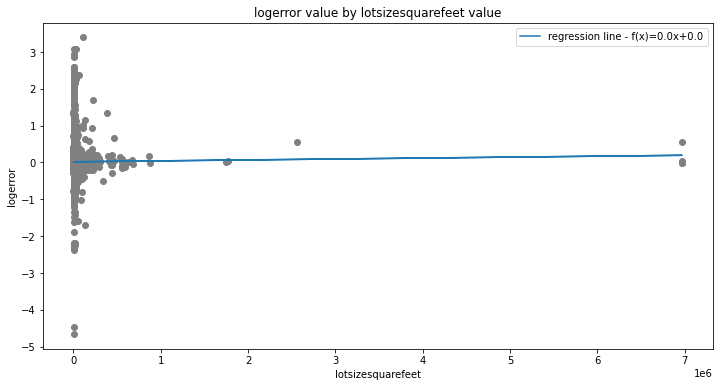

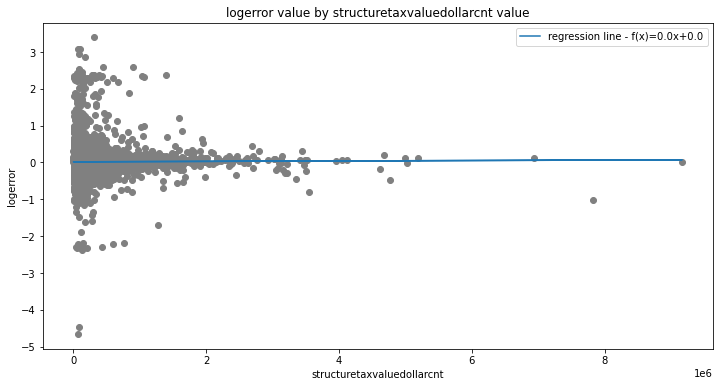

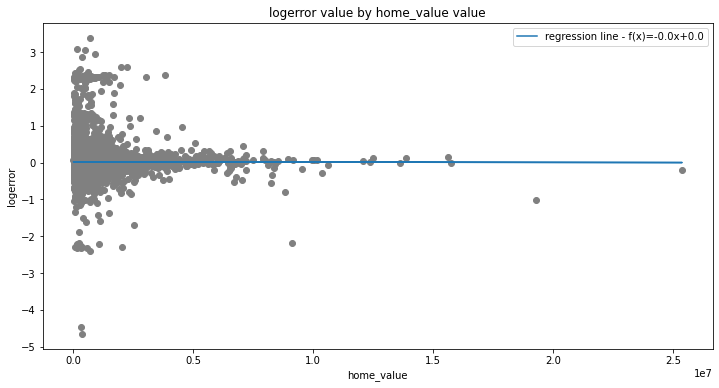

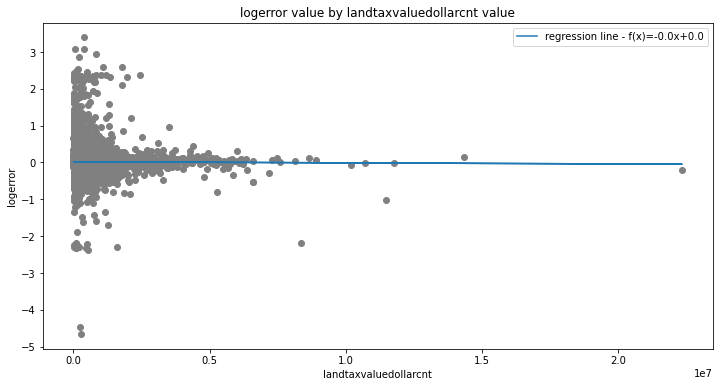

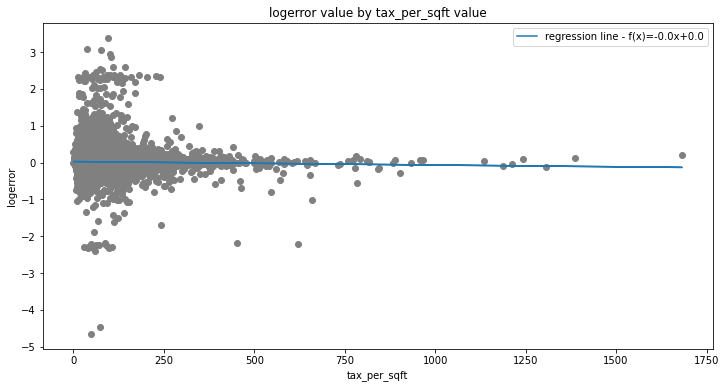

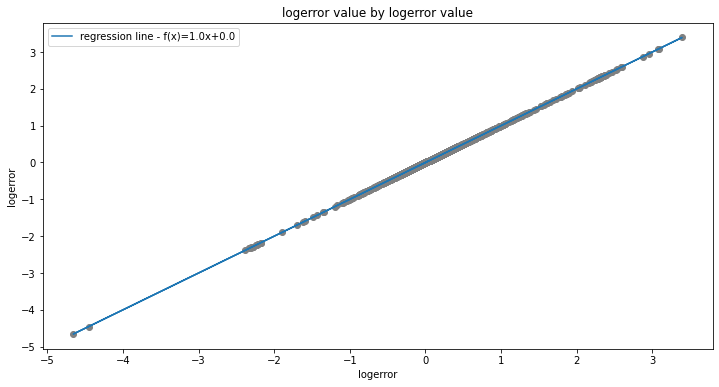

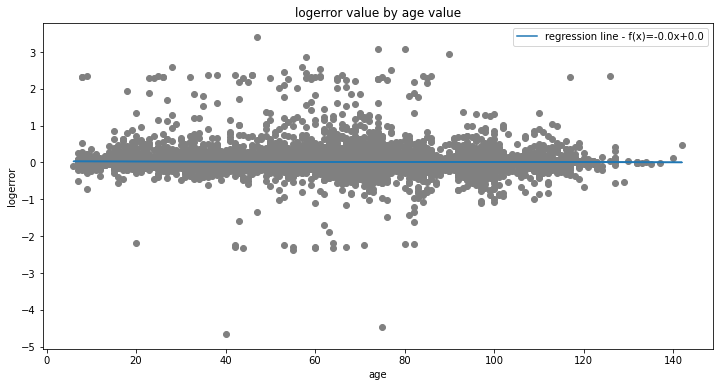

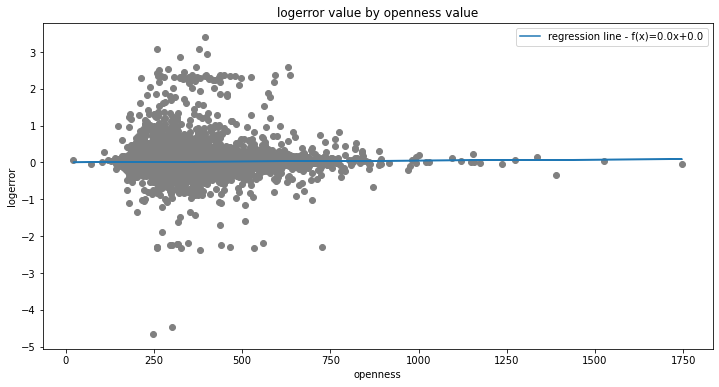

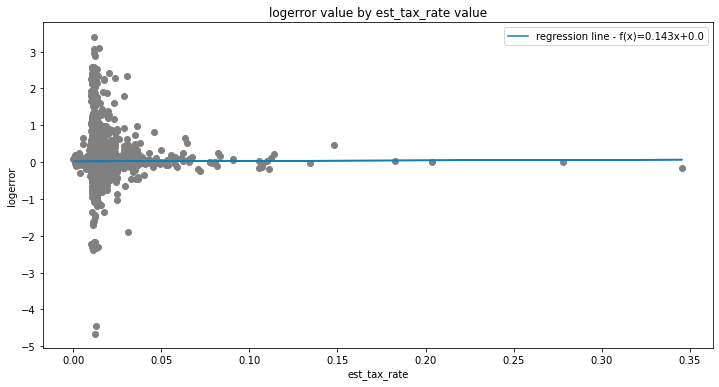

In [6]:
for col1 in continous_list:
            plt.figure(figsize=(12, 6))
            x=train[col1]
            y=train[target]
            plt.plot(x, y, "o",color="grey")
            m,b = np.polyfit(x,y,1)
            plt.plot(x,m*x+b,label=f"regression line - f(x)={round(m,3)}x+{round(b,1)}")
            plt.xlabel(col1)
            plt.ylabel(target)
            plt.legend()
            plt.title(f"{target} value by {col1} value")
            plt.show()

In [7]:
test_results = pd.DataFrame(columns=['test', 'var1', "var2", "comparing on", "test_value", "p_val"])

cat="logerror_bin"

for num in continous_list:

    alpha = .05

    for cat_1 in train[cat].unique():
        for cat_2 in train[cat].unique():
            if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
                
                stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
                stat,pval
                if pval > 0.05:
                    equal_var_flag = True
                else:
                    equal_var_flag = False

                t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )

                test_results.loc[len(test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                                f"{cat}({cat_1})",
                                                                f"{cat}({cat_2})",
                                                                num,
                                                                t,
                                                                p]
test_results

,test,var1,var2,comparing on,test_value,p_val
0,"ttest 2 sided, sample to sample",logerror_bin(-1sig~1sig),logerror_bin(<-1sig),basementsqft,-1.895254,5.836063e-02
1,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<-1sig),basementsqft,0.063100,9.496926e-01
2,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),basementsqft,1.178010,2.389898e-01
3,"ttest 2 sided, sample to sample",logerror_bin(-1sig~1sig),logerror_bin(<-1sig),area,0.617164,5.372703e-01
4,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<-1sig),area,1.911413,5.607279e-02
5,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),area,2.231444,2.579919e-02
6,"ttest 2 sided, sample to sample",logerror_bin(-1sig~1sig),logerror_bin(<-1sig),garagetotalsqft,12.687392,2.090073e-34
7,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<-1sig),garagetotalsqft,6.182061,7.474688e-10
8,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),garagetotalsqft,-3.997405,6.702564e-05
9,"ttest 2 sided, sample to sample",logerror_bin(-1sig~1sig),logerror_bin(<-1sig),latitude,-3.780091,1.657766e-04


In [8]:
num="logerror"
for cat in discrete_list:

    alpha = .05

    for cat_1 in train[cat].unique():
        for cat_2 in train[cat].unique():
            if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
                H0 = f"{num} of {cat}{cat_1} has identical average values to {num} of other {cat}{cat_2}"
                Ha = f"{num} of {cat} is not equal to {num} of other {cat}"
                stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
                stat,pval
                if pval > 0.05:
                    equal_var_flag = True
                else:
                    equal_var_flag = False

                t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )

                test_results.loc[len(test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                                f"{cat}({cat_1})",
                                                                f"{cat}({cat_2})",
                                                                num,
                                                                t,
                                                                p]
test_results


,test,var1,var2,comparing on,test_value,p_val
0,"ttest 2 sided, sample to sample",logerror_bin(-1sig~1sig),logerror_bin(<-1sig),basementsqft,-1.895254,0.058361
1,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<-1sig),basementsqft,0.063100,0.949693
2,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(-1sig~1sig),basementsqft,1.178010,0.238990
3,"ttest 2 sided, sample to sample",logerror_bin(-1sig~1sig),logerror_bin(<-1sig),area,0.617164,0.537270
4,"ttest 2 sided, sample to sample",logerror_bin(>1sig),logerror_bin(<-1sig),area,1.911413,0.056073
...,...,...,...,...,...,...
346,"ttest 2 sided, sample to sample",heating(Radiant),heating(None),logerror,-0.260548,0.794446
347,"ttest 2 sided, sample to sample",heating(Radiant),heating(Central),logerror,-0.162562,0.870866
348,"ttest 2 sided, sample to sample",heating(Radiant),heating(Solar),logerror,-0.063348,0.949850
349,"ttest 2 sided, sample to sample",heating(Radiant),heating(Forced air),logerror,-0.224557,0.822495


In [9]:
test_results.p_val.value_counts(dropna=False)

NaN              50
0.000000e+00      2
4.702434e-139     2
4.423342e-221     2
6.337122e-01      1
                 ..
5.561529e-01      1
6.078607e-01      1
4.154022e-02      1
2.607399e-01      1
6.037222e-01      1
Name: p_val, Length: 299, dtype: int64

In [10]:
test_results[test_results.p_val.isna()]

,test,var1,var2,comparing on,test_value,p_val
153,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(1.0),logerror,NaN,NaN
154,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(2.0),logerror,NaN,NaN
155,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(2.5),logerror,NaN,NaN
156,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(4.0),logerror,NaN,NaN
157,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(3.0),logerror,NaN,NaN
158,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(6.0),logerror,NaN,NaN
159,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(1.5),logerror,NaN,NaN
160,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(5.0),logerror,NaN,NaN
161,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(3.5),logerror,NaN,NaN
162,"ttest 2 sided, sample to sample",bathrooms(13.0),bathrooms(4.5),logerror,NaN,NaN


# # is the average of the sample "bedrooms (2-5)" equal to the population of bedrooms regarding log error

In [11]:
num="logerror"
alpha = .05

bedroom_list = [2.0,3.0,4.0,5.0]

for each in bedroom_list:

    population_name = "bedrooms"
    sample_name = each
    target = target
    
    H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
    Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

    print("-----------------------------")
    print(f"mean of sample = {round(train[train[population_name] == sample_name][target].mean(),3)}, \
        std of sample = {round(train[train[population_name] == sample_name][target].std(),3)}, \
            count of sample = {len(train[train[population_name] == sample_name][target])}")
    print(f"mean of pop = {round(train[target].mean(),3)}, std of pop = {round(train[target].std(),3)}")


    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
    if p > alpha:
        print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
    else:
        print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


-----------------------------
mean of sample = 0.014,         std of sample = 0.199,             count of sample = 4637
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 2̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶e̶d̶r̶o̶o̶m̶s̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=-1.99028, p=0.04662
-----------------------------
mean of sample = 0.014,         std of sample = 0.173,             count of sample = 12997
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 3̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶e̶d̶r̶o̶o̶m̶s̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=-3.42416, p=0.00062
-----------------------------
mean of sample = 0.025,         std of sample = 0.191,             count of sample = 8401
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 4̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶

2,3 and 5 bedrooms are deviant

# # is the average of the sample "bathroom (2-5)" equal to the population of bathrooms regarding log error

In [12]:
num="logerror"
alpha = .05

bathroom_list = [2.0,3.0,4.0,5.0]

for each in bathroom_list:

    population_name = "bathrooms"
    sample_name = each
    target = target
    
    H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
    Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

    print("-----------------------------")
    print(f"mean of sample = {round(train[train[population_name] == sample_name][target].mean(),3)}, \
        std of sample = {round(train[train[population_name] == sample_name][target].std(),3)}, \
            count of sample = {len(train[train[population_name] == sample_name][target])}")
    print(f"mean of pop = {round(train[target].mean(),3)}, std of pop = {round(train[target].std(),3)}")


    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
    if p > alpha:
        print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
    else:
        print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))

-----------------------------
mean of sample = 0.014,         std of sample = 0.173,             count of sample = 12229
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 2̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶a̶t̶h̶r̶o̶o̶m̶s̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=-3.38851, p=0.00070
-----------------------------
mean of sample = 0.019,         std of sample = 0.15,             count of sample = 5841
mean of pop = 0.02, std of pop = 0.187

 We fail to reject the null hypothesis ( 3.0 as a sample has equal average values to bathrooms as a population regarding logerror ) t=-0.17792, p=0.85879
-----------------------------
mean of sample = 0.042,         std of sample = 0.226,             count of sample = 1193
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( 4̶.̶0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶b̶a̶t̶h̶r̶o

4 bathrooms are deviant

# is the average of the sample "large" equal to the population of home_size regarding log error

In [13]:
num="logerror"
alpha = .05

population_name = "home_size"
sample_name = "large"
target=target
   
H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

print("-----------------------------")
print(f"mean of sample = {round(train[train[population_name] == sample_name][target].mean(),3)}, \
    std of sample = {round(train[train[population_name] == sample_name][target].std(),3)}, \
        count of sample = {len(train[train[population_name] == sample_name][target])}")
print(f"mean of pop = {round(train[target].mean(),3)}, std of pop = {round(train[target].std(),3)}")


t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
if p > alpha:
    print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
else:
    print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


-----------------------------
mean of sample = 0.032,     std of sample = 0.204,         count of sample = 7090
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( l̶a̶r̶g̶e̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶h̶o̶m̶e̶_̶s̶i̶z̶e̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=5.23334, p=0.00000


# is the average of the sample "no heating" equal to the population of heating regarding log error

In [14]:
num="logerror"
alpha = .05

population_name = "heating"
sample_name = "None"
target=target
   
H0 = f"{sample_name} as a sample has equal average values to {population_name} as a population regarding {target}"
Ha = f"{sample_name} as a sample does not have equal average values to {population_name} as a population regarding {target}"

print("-----------------------------")
print(f"mean of sample = {round(train[train[population_name] == sample_name][target].mean(),3)}, \
    std of sample = {round(train[train[population_name] == sample_name][target].std(),3)}, \
        count of sample = {len(train[train[population_name] == sample_name][target])}")
print(f"mean of pop = {round(train[target].mean(),3)}, std of pop = {round(train[target].std(),3)}")


t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
if p > alpha:
    print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
else:
    print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


-----------------------------
mean of sample = 0.028,     std of sample = 0.204,         count of sample = 10197
mean of pop = 0.02, std of pop = 0.187

 We reject the null Hypothesis ( N̶o̶n̶e̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶h̶e̶a̶t̶i̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=4.02012, p=0.00006


# scaling for groups

## first group

In [15]:
dict_to_cluster = { "house_tax":["tax_per_sqft","est_tax_rate","openness"],
                    "house_details":["lotsizesquarefeet",'garagetotalsqft',"poolcnt"],
                    "house_sizing":['area', 'bathrooms', 'bedrooms'],
                    "house_locale":["latitude","longitude","age"],
                    "cluster_order":[5,4,5,5]}


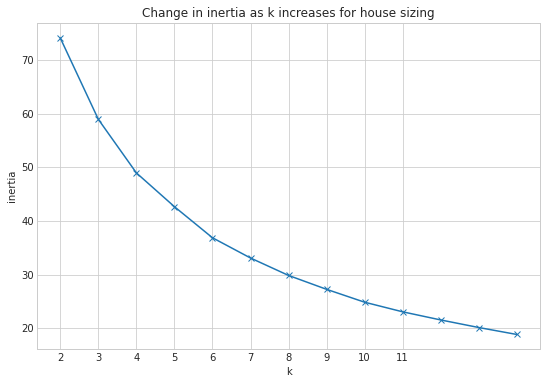

In [16]:
X = train[dict_to_cluster[list(dict_to_cluster)[0]]]
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for house sizing')

In [17]:
kmeans_scaled = KMeans(n_clusters=5)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)
train[f"cluster {list(dict_to_cluster)[0]}"] = X_scaled["cluster"]
X_scaled.groupby(["cluster"]).agg(["mean","min","max"])

tax_per_sqft                     est_tax_rate                      \
                mean       min       max         mean       min       max   
cluster                                                                     
0           0.039559  0.000070  0.120079     0.040555  0.000852  1.000000   
1           0.043412  0.000240  0.098481     0.037317  0.002465  0.235428   
2           0.076752  0.000000  0.264262     0.035038  0.000000  0.305246   
3           0.086462  0.051695  0.202111     0.034924  0.002763  0.095196   
4           0.292761  0.183764  1.000000     0.033236  0.003590  0.038936   

         openness                      
             mean       min       max  
cluster                                
0        0.142642  0.029146  0.190743  
1        0.209424  0.175093  0.272391  
2        0.295795  0.239112  1.000000  
3        0.176055  0.087571  0.241865  
4        0.216760  0.000000  0.445978

In [18]:
cluster_test_results = pd.DataFrame(columns=['test', 'population', "variable", "comparing on", "test_value", "p_val"])

num="logerror"
cat = f"cluster {list(dict_to_cluster)[0]}"
alpha = .05

for each in train[cat].unique():

    population_name = cat
    sample_name = each
    target = target
    
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())

    cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                            f"{cat}",
                                                            f"{cat}({each})",
                                                            num,
                                                            t,
                                                            p]
cluster_test_results.sort_values(by=["p_val"])

,test,population,variable,comparing on,test_value,p_val
2,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(3),logerror,-4.264035,0.000020
1,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(2),logerror,3.365629,0.000775
4,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(4),logerror,-2.803032,0.005563
0,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(1),logerror,1.594574,0.110846
3,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(0),logerror,-0.430145,0.667097


## Second group

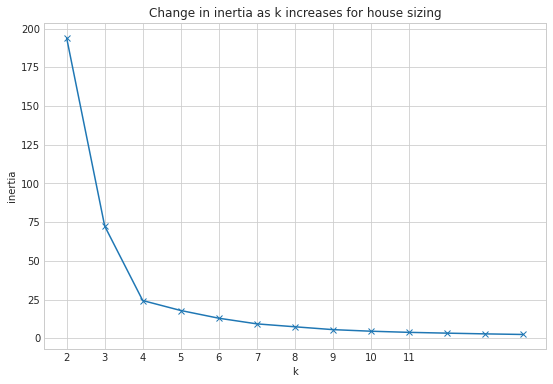

In [19]:
X = train[dict_to_cluster[list(dict_to_cluster)[1]]]
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for house sizing')



In [20]:
kmeans_scaled = KMeans(n_clusters=4)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)

train[f"cluster {list(dict_to_cluster)[1]}"] = X_scaled["cluster"]
X_scaled.groupby(["cluster"]).agg(["mean","min","max"])

lotsizesquarefeet                     garagetotalsqft            \
                     mean       min       max            mean       min   
cluster                                                                   
0                0.001683  0.000044  1.000000        0.000626  0.000000   
1                0.002168  0.000083  0.367538        0.000232  0.000000   
2                0.000993  0.000061  0.037967        0.156650  0.078652   
3                0.001783  0.000000  0.063081        0.182518  0.096308   

                  poolcnt            
              max    mean  min  max  
cluster                              
0        0.078331     0.0  0.0  0.0  
1        0.089888     1.0  1.0  1.0  
2        0.931300     0.0  0.0  0.0  
3        1.000000     1.0  1.0  1.0

In [21]:

num="logerror"
cat = f"cluster {list(dict_to_cluster)[1]}"
alpha = .05

for each in train[cat].unique():

    population_name = cat
    sample_name = each
    target = target
    
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())

    cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                            f"{cat}",
                                                            f"{cat}({each})",
                                                            num,
                                                            t,
                                                            p]
cluster_test_results.sort_values(by=["p_val"])

,test,population,variable,comparing on,test_value,p_val
2,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(3),logerror,-4.264035,0.000020
8,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(2),logerror,3.964288,0.000074
1,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(2),logerror,3.365629,0.000775
4,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(4),logerror,-2.803032,0.005563
7,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(1),logerror,-2.725889,0.006442
5,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(0),logerror,-1.729775,0.083690
0,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(1),logerror,1.594574,0.110846
6,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(3),logerror,0.639394,0.522630
3,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(0),logerror,-0.430145,0.667097


## Third group

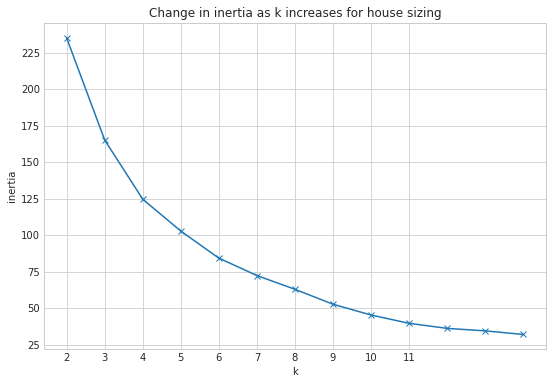

In [22]:
X = train[dict_to_cluster[list(dict_to_cluster)[2]]]
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for house sizing')



In [23]:
kmeans_scaled = KMeans(n_clusters=5)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)

train[f"cluster {list(dict_to_cluster)[2]}"] = X_scaled["cluster"]

X_scaled.groupby(["cluster"]).agg(["mean","min","max"])

area                     bathrooms                      bedrooms  \
             mean       min       max      mean       min       max      mean   
cluster                                                                         
0        0.102120  0.022483  0.275171  0.225428  0.153846  0.576923  0.267274   
1        0.047815  0.006647  0.163343  0.102505  0.000000  0.230769  0.174834   
2        0.099380  0.000000  0.241593  0.198292  0.076923  0.307692  0.377802   
3        0.197186  0.076882  1.000000  0.357753  0.230769  1.000000  0.434443   
4        0.062649  0.023363  0.173754  0.136133  0.000000  0.192308  0.274057   

                             
              min       max  
cluster                      
0        0.000000  0.272727  
1        0.000000  0.181818  
2        0.363636  0.636364  
3        0.272727  1.000000  
4        0.272727  0.363636

In [24]:

num="logerror"
cat = f"cluster {list(dict_to_cluster)[2]}"
alpha = .05

for each in train[cat].unique():

    population_name = cat
    sample_name = each
    target = target
    
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())

    cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                            f"{cat}",
                                                            f"{cat}({each})",
                                                            num,
                                                            t,
                                                            p]
cluster_test_results.sort_values(by=["p_val"])

,test,population,variable,comparing on,test_value,p_val
13,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(3),logerror,5.889077,4.473734e-09
2,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(3),logerror,-4.264035,2.044639e-05
8,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(2),logerror,3.964288,7.431146e-05
1,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(2),logerror,3.365629,7.748685e-04
10,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(4),logerror,-2.875420,4.043436e-03
4,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(4),logerror,-2.803032,5.563317e-03
7,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(1),logerror,-2.725889,6.441840e-03
12,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(0),logerror,-2.138405,3.255638e-02
5,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(0),logerror,-1.729775,8.369048e-02
9,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(1),logerror,-1.677024,9.360306e-02


## Fourth (last) group

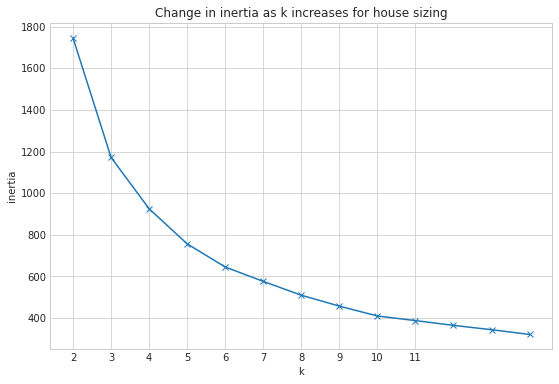

In [25]:
X = train[dict_to_cluster[list(dict_to_cluster)[3]]]
# make, fit, apply:
scaler = MinMaxScaler()
# train is all numerical so I can call the whole thing
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    index = X.index,
    columns = X.columns)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 15)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for house sizing')



In [26]:
kmeans_scaled = KMeans(n_clusters=5)
kmeans_scaled.fit(X_scaled)
X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)

train[f"cluster {list(dict_to_cluster)[3]}"] = X_scaled["cluster"]
X_scaled.groupby(["cluster"]).agg(["mean","min","max"])

latitude                     longitude                           age  \
             mean       min       max      mean       min       max      mean   
cluster                                                                         
0        0.502097  0.217115  0.915771  0.604122  0.092762  0.914369  0.566442   
1        0.373977  0.000000  0.582999  0.757266  0.546302  0.985173  0.420191   
2        0.605367  0.370573  0.789044  0.360969  0.000000  0.621899  0.298311   
3        0.227517  0.035440  0.548223  0.886626  0.555198  1.000000  0.209564   
4        0.828840  0.491635  1.000000  0.672053  0.426474  0.948320  0.207158   

                             
              min       max  
cluster                      
0        0.330882  1.000000  
1        0.117647  0.801471  
2        0.000000  0.720588  
3        0.007353  0.507353  
4        0.007353  0.580882

In [27]:

num="logerror"
cat = f"cluster {list(dict_to_cluster)[3]}"
alpha = .05

for each in train[cat].unique():

    population_name = cat
    sample_name = each
    target = target
    
    t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())

    cluster_test_results.loc[len(cluster_test_results.index)] = ["ttest 2 sided, sample to sample", 
                                                            f"{cat}",
                                                            f"{cat}({each})",
                                                            num,
                                                            t,
                                                            p]
cluster_test_results.sort_values(by=["p_val"])

,test,population,variable,comparing on,test_value,p_val
13,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(3),logerror,5.889077,4.473734e-09
14,"ttest 2 sided, sample to sample",cluster house_locale,cluster house_locale(0),logerror,-5.022896,5.202106e-07
15,"ttest 2 sided, sample to sample",cluster house_locale,cluster house_locale(3),logerror,4.695261,2.740329e-06
2,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(3),logerror,-4.264035,2.044639e-05
8,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(2),logerror,3.964288,7.431146e-05
1,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(2),logerror,3.365629,7.748685e-04
10,"ttest 2 sided, sample to sample",cluster house_sizing,cluster house_sizing(4),logerror,-2.875420,4.043436e-03
4,"ttest 2 sided, sample to sample",cluster house_tax,cluster house_tax(4),logerror,-2.803032,5.563317e-03
7,"ttest 2 sided, sample to sample",cluster house_details,cluster house_details(1),logerror,-2.725889,6.441840e-03
17,"ttest 2 sided, sample to sample",cluster house_locale,cluster house_locale(1),logerror,2.150009,3.157980e-02


In [28]:
train.head().T

id,2276667,2965061,2047898,933582,2978060
basementsqft,0.0,0.0,0.0,0.0,0.0
bathrooms,1.0,2.0,1.0,1.0,2.5
bedrooms,2.0,3.0,2.0,3.0,4.0
area,1092.0,1712.0,1620.0,1270.0,2092.0
county,LA County,Orange County,LA County,LA County,Orange County
garagecarcnt,0.0,2.0,0.0,0.0,2.0
garagetotalsqft,0.0,441.0,0.0,0.0,441.0
latitude,34064326.0,33545028.0,34018464.0,33993715.0,33793010.0
longitude,-118049996.0,-117675259.0,-118794354.0,-118056183.0,-118073478.0
lotsizesquarefeet,9771.0,8494.0,44577.0,5562.0,7700.0


In [37]:
dict_to_cluster[list(dict_to_cluster)[len(list(dict_to_cluster))-1]][2]

5

In [34]:
len(list(dict_to_cluster))

5

In [30]:
for i in range(len(list(dict_to_cluster))):
    print(i)

0
1
2
3
4


In [40]:
def get_kmeans_cluster_features(df,dict_to_cluster):
    ''' 
    takes in your three datasets to apply the new featuers to as well as
    a dictionary (iterable lists with the last being the order of clustering (function to auto later))
    '''

    for i in range(len(list(dict_to_cluster))-1):
        #set features
        X = df[dict_to_cluster[list(dict_to_cluster)[i]]]
        # make, fit, apply:
        scaler = MinMaxScaler()
        # train is all numerical so I can call the whole thing
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X),
            index = X.index,
            columns = X.columns)

        kmeans_scaled = KMeans(n_clusters=dict_to_cluster[list(dict_to_cluster)[len(list(dict_to_cluster))-1]][i])
        kmeans_scaled.fit(X_scaled)

        X_scaled["cluster"] = kmeans_scaled.predict(X_scaled)

        df[f"cluster {list(dict_to_cluster)[i]}"] = X_scaled["cluster"]
    return df

In [41]:
df = get_kmeans_cluster_features(df,dict_to_cluster)